# Unzip the data

In [8]:
import os
import zipfile

local_zip = 'Train_UQcUa52.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('data')
zip_ref.close()

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("Test_fCbTej3_0j1gHmj.csv")

In [3]:
train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


In [4]:
train.shape, test.shape

((49000, 2), (21000, 1))

In [5]:
train['label'] = train['label'].astype('str')
classes = train.label.unique().tolist()
classes

['4', '9', '1', '7', '3', '2', '6', '0', '8', '5']

# Data Cleaning and Segregation

* Into train and validation set

In [9]:
import shutil
import random

train_directory = '.\\training'
val_directory = '.\\validation'

#os.mkdir(train_directory)
#os.mkdir(val_directory)

train_file_dir = '.\\data\\Images\\train'

files_toshow = []
labels_toshow = []

for class_ in classes:
    path_train = os.path.join(train_directory, class_)
    path_val = os.path.join(val_directory, class_)
    
    print(path_val)
    
    if os.path.isdir(path_train) | os.path.isdir(path_val):
        print('Already exists')
        filenames = train.groupby('label')['filename'].get_group(class_).tolist()
        labels_toshow.append([class_] * 2)
        files_toshow.append([(train_file_dir + os.sep + file) 
                             for file in random.sample(filenames, 2)])
        
    else:
        os.mkdir(path_train)
        os.mkdir(path_val)
        
        print('Directory Created ', path_train)
        print('Directory Created ', path_val)
        
        filenames = train.groupby('label')['filename'].get_group(class_).tolist()
        
        val_files = random.sample(filenames, 500)
        train_files = [file for file in filenames if file not in val_files]
        
        files_toshow.append([(train_file_dir + os.sep + file) 
                             for file in random.sample(filenames, 2)])
        labels_toshow.append([class_] * 2)
        
        source = [(train_file_dir + os.sep + file) for file in train_files]
        for f in source:
            shutil.copy(f, path_train)
        print('Class ', class_, ' Images Moved in Training Folder')
        print(class_,' having ', len(train_files), ' files in Training Folder')
        
        source = [(train_file_dir + os.sep + file) for file in val_files]
        for f in source:
            shutil.copy(f, path_val)
        print('Class ', class_, ' Images Moved in Validation Folder')
        print(class_,' having ', len(val_files), ' files in Validation Folder')

.\validation\4
Already exists
.\validation\9
Already exists
.\validation\1
Already exists
.\validation\7
Already exists
.\validation\3
Already exists
.\validation\2
Already exists
.\validation\6
Already exists
.\validation\0
Already exists
.\validation\8
Already exists
.\validation\5
Already exists


# Visualization

In [10]:
from matplotlib.cbook import flatten
files = list(flatten(files_toshow))
labels_train = list(flatten(labels_toshow))

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 4
ncols = 5
pic_index = 0

<Figure size 432x288 with 0 Axes>

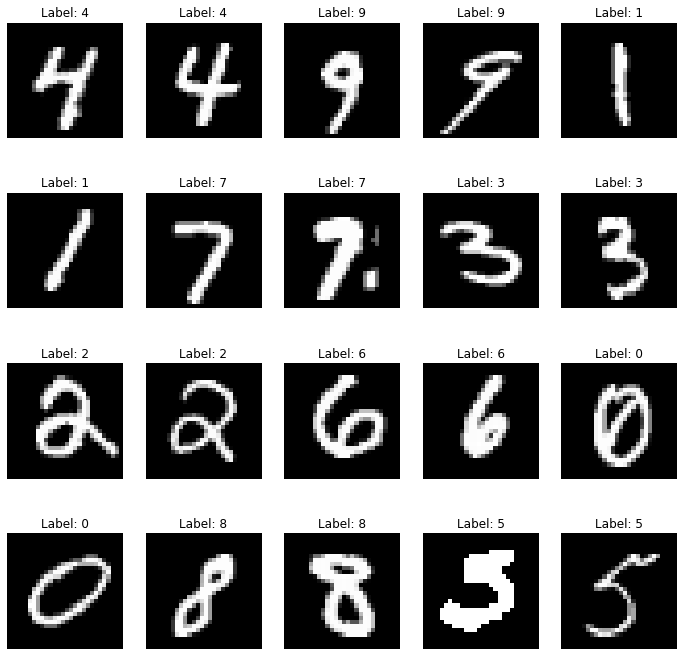

In [12]:
fig = plt.gcf()
plt.figure(figsize=(12,12))

for i, img_path in enumerate(files):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.title("Label: "+labels_train[i])
    plt.imshow(img)

plt.show()

# Tensorflow Modelling (Neural Network)
* 1 CNN of 16 neurons
* 1 MaxPooling
* 1024 Neurons (Hidden Layer)
* 512 Neurons (Hidden Layer)
* 10 Neurons (Output layer)

In [20]:
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow import keras
tf.keras.backend.clear_session()

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(28, 28), 
    color_mode='grayscale',
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    val_directory,
    target_size=(28, 28), 
    color_mode='grayscale',
    class_mode='categorical')

Found 44000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.


In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2704)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2769920   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 3,300,010
Trainable params: 3,300,010
Non-trainable params: 0
______________________________________________

In [23]:
from tensorflow.keras.optimizers import RMSprop, SGD, Adamax
tf.enable_eager_execution()

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [24]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        print(logs.get('val_acc'))
        if(logs.get('val_acc')>=0.98):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True
        return
            
callbacks = myCallback()

history = model.fit(
    train_generator,
    epochs=15,
    verbose=1,
    validation_data = validation_generator, 
    callbacks=[callbacks])

Epoch 1/15
1375/1375 [==============================] - 55s 40ms/step - loss: 0.1503 - acc: 0.9539 - val_loss: 0.0762 - val_acc: 0.9784
Epoch 2/15
1374/1375 [============================>.] - ETA: 0s - loss: 0.0492 - acc: 0.98420.9838

Reached 98% accuracy so cancelling training!
1375/1375 [==============================] - 59s 43ms/step - loss: 0.0492 - acc: 0.9842 - val_loss: 0.0588 - val_acc: 0.9838


In [25]:
if not os.path.exists('./asaved_model'):
    os.makedirs('./asaved_model')
model.save('./asaved_model/cnn_model')

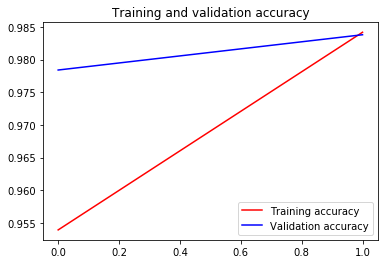

<Figure size 432x288 with 0 Axes>

In [26]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

# CNN Analysis

C:\Users\hungu\anaconda.x\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


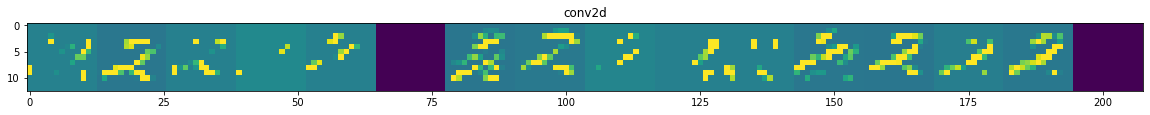

In [18]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

img = load_img(files[10], target_size=(28, 28), color_mode='rgba')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x /= 255
successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Predicting Test set

In [19]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(train.label)

LabelEncoder()

In [20]:
test_file_dir = '.\\data\\Images\\test'

test_fn = test.filename.tolist()
test_files_path = [(test_file_dir + os.sep + file) for file in test_fn]

In [21]:
len(test_files_path), test.shape

(21000, (21000, 1))

In [22]:
from tensorflow.keras.preprocessing import image

pred_test = []
fns = []

for fn in test_files_path:
    path = fn
    img = image.load_img(path, target_size=(28, 28), color_mode='rgba')
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    pred_test.append(np.argmax(classes))
    fns.append(fn)

In [23]:
df = {'filename':test.filename, 'label':encoder.inverse_transform(pred_test)}
submission = pd.DataFrame(df)
submission.to_csv('sub.csv', index=False)

In [24]:
submission.head()

,filename,label
0,49000.png,4
1,49001.png,0
2,49002.png,9
3,49003.png,7
4,49004.png,9


# Test Data Visualization

In [25]:
test_files = submission.sample(16)
files_test = [(test_file_dir + os.sep + file) for file in test_files.filename.tolist()]
label_test = test_files.label.tolist()

<Figure size 432x288 with 0 Axes>

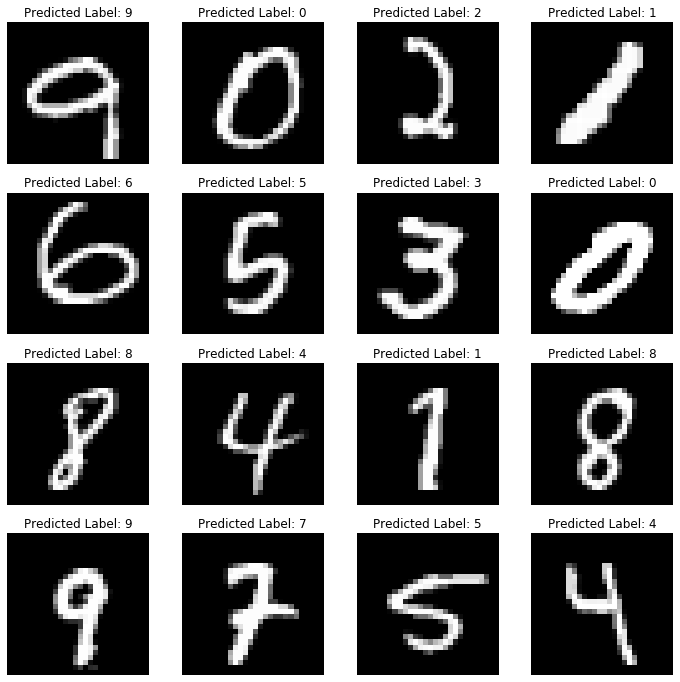

In [26]:
nrows = 4
ncols = 4
pic_index = 0

fig = plt.gcf()
plt.figure(figsize=(12,12))

for i, img_path in enumerate(files_test):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.title("Predicted Label: "+label_test[i])
    plt.imshow(img)

plt.show()